In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

#file path
fp = r"C:\Users\renhu\OneDrive\Desktop\205.2 DATA\rawdata\Average_Daily_Traffic_Counts.geojson"

#read file
traffic = gpd.read_file(fp)
print("origional shape:", traffic.shape)
print("Columns:", list(traffic.columns))

#keep columns 
keep_cols = [ "road_id", "road_name", "start_name", "end_name",
    "location", "latest", "count_date", "peak_hour",
    "adt", "peaktraffic",
    "pccar", "pclcv", "pcmcv", "pchcvi", "pchcvii", "pcbus", "pcheavy",
    "geometry"
]
traffic = traffic[[col for col in keep_cols if col in traffic.columns]].copy()


origional shape: (13093, 23)
Columns: ['OBJECTID', 'carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name', 'location', 'latest', 'count_date', 'peak_hour', 'count_duration', 'adt', 'peaktraffic', 'pccar', 'pclcv', 'pcmcv', 'pchcvi', 'pchcvii', 'pcbus', 'pcheavy', 'NZTMX', 'NZTMY', 'geometry']


In [2]:
traffic.isna().sum().sort_values(ascending=False)

peaktraffic    3251
peak_hour      3217
pcbus          1182
pchcvii        1174
pcheavy        1076
pccar          1076
pclcv          1076
pcmcv          1076
pchcvi         1076
location        298
adt             119
end_name         68
start_name       55
road_name         1
road_id           0
count_date        0
latest            0
geometry          0
dtype: int64

In [3]:
traffic.geometry.is_valid.sum(), len(traffic)
traffic.geometry.notnull().sum()

13093

In [4]:
traffic["adt"].dtype
traffic["adt"].head(10)
traffic["adt"].unique()[:10]  # or .sample(10)
traffic["adt"].isna().sum()

119

In [5]:
traffic = traffic.dropna(subset=["adt", "geometry"])
print("Clean shape:", traffic.shape)

Clean shape: (12974, 18)


In [6]:
#impute missing vehicle category percentages with median
pct_cols = ["pccar", "pclcv", "pcmcv", "pchcvi", "pchcvii", "pcbus", "pcheavy"]
traffic[pct_cols] = traffic[pct_cols].apply(lambda x: x.fillna(x.median()))

#fill missing location names
traffic["location"] = traffic["location"].fillna("unknown")

#drop peak_hour (too many missing)
traffic = traffic.drop(columns=["peak_hour"])

#impute peaktraffic with median
traffic["peaktraffic"] = traffic["peaktraffic"].fillna(traffic["peaktraffic"].median())

#check 'latest' before filtering
if "latest" in traffic.columns:
    print("Latest column unique values:", traffic["latest"].unique())
    #filter if 'Y' exists
    if "Y" in traffic["latest"].unique():
        traffic = traffic[traffic["latest"] == "Y"]

#reset index
traffic.reset_index(drop=True, inplace=True)

#save
processed_folder = r"C:\Users\renhu\OneDrive\Desktop\205.2 DATA\processed"
os.makedirs(processed_folder, exist_ok=True)
output_file = os.path.join(processed_folder, "Average_Daily_Traffic_Clean.geojson")
traffic.to_file(output_file, driver="GeoJSON")

print("Final cleaned dataset saved!")
print("Shape:", traffic.shape)


Latest column unique values: ['Yes']
Final cleaned dataset saved!
Shape: (12974, 17)


In [7]:
#clean up texts 
text_cols = ["road_name", "start_name", "end_name", "location"]
for col in text_cols:
    if col in traffic.columns:
        traffic[col] = traffic[col].astype(str).str.strip().str.lower().replace("nan", np.nan)

In [8]:
num_cols = ["adt", "peaktraffic", "pccar", "pclcv", "pcmcv", "pchcvi", "pchcvii", "pcbus", "pcheavy"]

for col in num_cols:
    if col in traffic.columns:
        #convert to numeric, coerce errors to NaN
        traffic[col] = pd.to_numeric(traffic[col], errors="coerce")

#impute remaining missing with median
traffic[num_cols] = traffic[num_cols].fillna(traffic[num_cols].median())
        

In [19]:
import geopandas as gpd 
import pandas as pd
import numpy as np
import os       

# file path for roadworks
roadworks_fp = r"C:\Users\mathe\Downloads\Roadworks (1).geojson"

# Read the roadworks dataset
roadworks = gpd.read_file(roadworks_fp)
print("Roadworks shape:", roadworks.shape)
print("Roadworks Columns:", list(roadworks.columns))


Roadworks shape: (2519, 15)
Roadworks Columns: ['OBJECTID', 'WorksiteCode', 'WorksiteName', 'ProjectName', 'Status', 'WorksiteType', 'Shape__Area', 'Shape__Length', 'PrincipalOrganisation', 'ProjectStartDate', 'ProjectEndDate', 'WorkStartDate', 'WorkCompletionDate', 'WorkStatus', 'geometry']


In [20]:
# Keeping the relevant columns
roadworks_keep_cols = [
    "WorksiteName",
    "StartDate",
    "EndDate", 
    "Status",
    "WorksiteType",
    "PrincipalOrganisation",
    "WorkStatus",
    "geometry"
]

roadworks = roadworks[[col for col in roadworks_keep_cols if col in roadworks.columns]].copy()
print("Roadworks shape after keeping relevant columns:", roadworks.shape)
print("kept columns:", list(roadworks.columns))

Roadworks shape after keeping relevant columns: (2519, 6)
kept columns: ['WorksiteName', 'Status', 'WorksiteType', 'PrincipalOrganisation', 'WorkStatus', 'geometry']


In [21]:
# Data quality checks
print("\nMissing values in roadworks data:")
print(roadworks.isnull().sum().sort_values(ascending=False))

print(f"\nValid geometries: {roadworks.geometry.is_valid.sum()} out of {len(roadworks)}")


Missing values in roadworks data:
WorksiteName             0
Status                   0
WorksiteType             0
PrincipalOrganisation    0
WorkStatus               0
geometry                 0
dtype: int64

Valid geometries: 2519 out of 2519


In [ ]:
# Cleaning the text columns
text_cols = [
    "WorksiteName",
    "Status",
    "WorksiteType",
    "PrincipalOrganisation",
    "WorkStatus",
    "StartDate",
    "EndDate",
]

for col in text_cols:
    roadworks[col] = roadworks[col].str.strip().str.lower()
    roadworks[col] = roadworks[col].replace("nan", np.nan)

print("\nAfter cleaning text columns:")
print(roadworks[text_cols].head())


After cleaning text columns:
                                        WorksiteName  Status    WorksiteType  \
0           85 custom street east, auckland central.  active  non-excavation   
1  39 hinemoa street, birkenhead - tree maintaine...  active  non-excavation   
2                         ho128- manukau road, epsom  active  non-excavation   
3          55 tauhinu rd, greenhithe  m.0193675.h.25  active      excavation   
4  2406 – 022epa - sky - 20 waimana ave, northcot...  active      excavation   

    PrincipalOrganisation        WorkStatus  
0  shundi customs limited           started  
1        auckland council  pending warranty  
2        auckland council           started  
3          vector limited    ready to start  
4            fuxuan zhang           started  


In [40]:
# Handle date columns
date_cols = ["StartDate", "EndDate"]
for col in date_cols:
	if col in roadworks.columns:
		roadworks[col] = pd.to_datetime(roadworks[col], errors="coerce")
	else:
		print(f"Column '{col}' not found in roadworks DataFrame.")
print("\nAfter converting date columns:")
print(roadworks[[col for col in date_cols if col in roadworks.columns]].dtypes)

Column 'StartDate' not found in roadworks DataFrame.
Column 'EndDate' not found in roadworks DataFrame.

After converting date columns:
Series([], dtype: object)


In [25]:
# Handle missing values and creating new features
categorical_cols = [
    "WorksiteName",
    "Status",
    "WorksiteType",
    "PrincipalOrganisation",
    "WorkStatus",
] 
for col in categorical_cols:
    roadworks[col] = roadworks[col].fillna("unknown")

    if "WorkStatus" in roadworks.columns:
        roadworks["WorkStatus_Simple"] = roadworks["WorkStatus"].apply(
            lambda x: "active" if "start" in str(x) else
            "planned" if "planned" in str(x) else 
             "completed" if "complete" in str(x) else 
             "other"
        )

    roadworks.reset_index(drop=True, inplace=True)
    print("\nAfter handling missing values and creating new features:")
    print(roadworks.head())



After handling missing values and creating new features:
                                        WorksiteName  Status    WorksiteType  \
0           85 custom street east, auckland central.  active  non-excavation   
1  39 hinemoa street, birkenhead - tree maintaine...  active  non-excavation   
2                         ho128- manukau road, epsom  active  non-excavation   
3          55 tauhinu rd, greenhithe  m.0193675.h.25  active      excavation   
4  2406 – 022epa - sky - 20 waimana ave, northcot...  active      excavation   

    PrincipalOrganisation        WorkStatus  \
0  shundi customs limited           started   
1        auckland council  pending warranty   
2        auckland council           started   
3          vector limited    ready to start   
4            fuxuan zhang           started   

                                            geometry WorkStatus_Simple  
0  POLYGON ((174.76882 -36.84511, 174.77029 -36.8...            active  
1  POLYGON ((174.73634 -36.81924

In [26]:
# Saving the cleaned roadworks dataset
processed_folder = r"C:\Users\mathe\Documents\GitHub\205.2-assessment\205.2 DATA\processed"
os.makedirs(processed_folder, exist_ok=True)
output_file = os.path.join(processed_folder, "Roadworks_Clean.geojson")
roadworks.to_file(output_file, driver="GeoJSON")

print("Cleaned roadworks dataset saved!")
print("Shape:", roadworks.shape)
print("Columns:", list(roadworks.columns))

print("\nRoadworks Summary:")
print(roadworks.describe(include='all'))
if "WorksiteType" in roadworks.columns:
    print("\nWorksiteType Value Counts:")
    print(roadworks["WorksiteType"].value_counts())
if "Status" in roadworks.columns:
    print("\nStatus Value Counts:")
    print(roadworks["Status"].value_counts())
if "WorkStatus_Simple" in roadworks.columns:
    print("\nWorkStatus_Simple Value Counts:")
    print(roadworks["WorkStatus_Simple"].value_counts())

Cleaned roadworks dataset saved!
Shape: (2519, 7)
Columns: ['WorksiteName', 'Status', 'WorksiteType', 'PrincipalOrganisation', 'WorkStatus', 'geometry', 'WorkStatus_Simple']

Roadworks Summary:
                                            WorksiteName  Status WorksiteType  \
count                                               2519    2519         2519   
unique                                              2512       2            3   
top     25_151_00-fibre - william pickering dr, rosedale  active   excavation   
freq                                                   2    2516         1829   

       PrincipalOrganisation WorkStatus  \
count                   2519       2519   
unique                   823          6   
top       auckland transport    started   
freq                     450       1560   

                                                 geometry WorkStatus_Simple  
count                                                2519              2519  
unique                      

In [5]:
# Importing libraries for infrastructure projects analysis
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")

All libraries imported successfully.


In [7]:
# importing infrastructure projects datasets
file_path = r"C:\Users\mathe\Downloads\AT_Infrastructure_Projects.geojson"
gdf = gpd.read_file(file_path)

print("Dataset shape: ", gdf.shape)
print("Columns:", gdf.columns.tolist())
print("\nFirst few rows:")
print(gdf.head())

Dataset shape:  (29672, 14)
Columns: ['ProjectNo', 'ProjectName', 'Programme', 'ProjectDescription', 'ProjectStartDate', 'ProjectEndDate', 'ConstructionStartDate', 'ProjectStatus', 'LocalBoard', 'ProjectSource', 'OBJECTID', 'SHAPE__Area', 'SHAPE__Length', 'geometry']

First few rows:
  ProjectNo                                        ProjectName  \
0    430277           Renewal - Resurfacing Works;FARM PARK RD   
1    344949  Renewal - Surface Water Channel;MASON AVE (PUK...   
2    674779                    Renewal - Footpath;PATUMAHOE RD   
3    713625  Renewal - Resurfacing Works;GREAT SOUTH RD (RA...   
4    670203           Renewal - Footpath;OPAHEKE RD (PAPAKURA)   

               Programme               ProjectDescription  \
0               Pavement      Renewal - Resurfacing Works   
1  Surface Water Channel  Renewal - Surface Water Channel   
2               Footpath               Renewal - Footpath   
3               Pavement      Renewal - Resurfacing Works   
4            

In [ ]:
# Detailed dataset information
print("\nDataset Info:")
print("=" * 50)
print(f"Number of features: {len(gdf)}")
print(f"Number of columns: {gdf.shape[1]}")
print(f"Column names: {gdf.columns.tolist()}")
print(f"CRS: {gdf.crs}")

print("\nData Types: ")
print("=" * 50)
print(gdf.dtypes)


Dataset Info:
Number of features: 29672
Number of columns: 14
Column names: ['ProjectNo', 'ProjectName', 'Programme', 'ProjectDescription', 'ProjectStartDate', 'ProjectEndDate', 'ConstructionStartDate', 'ProjectStatus', 'LocalBoard', 'ProjectSource', 'OBJECTID', 'SHAPE__Area', 'SHAPE__Length', 'geometry']
CRS: EPSG:4326

Data Types: 
ProjectNo                             object
ProjectName                           object
Programme                             object
ProjectDescription                    object
ProjectStartDate         datetime64[ms, UTC]
ProjectEndDate           datetime64[ms, UTC]
ConstructionStartDate    datetime64[ms, UTC]
ProjectStatus                         object
LocalBoard                            object
ProjectSource                         object
OBJECTID                               int32
SHAPE__Area                          float64
SHAPE__Length                        float64
geometry                            geometry
dtype: object


Missing Values Analysis:
                       Missing Values  Percentage (%)
ConstructionStartDate           28754       96.906174
LocalBoard                      28754       96.906174
ProjectDescription                280        0.943651


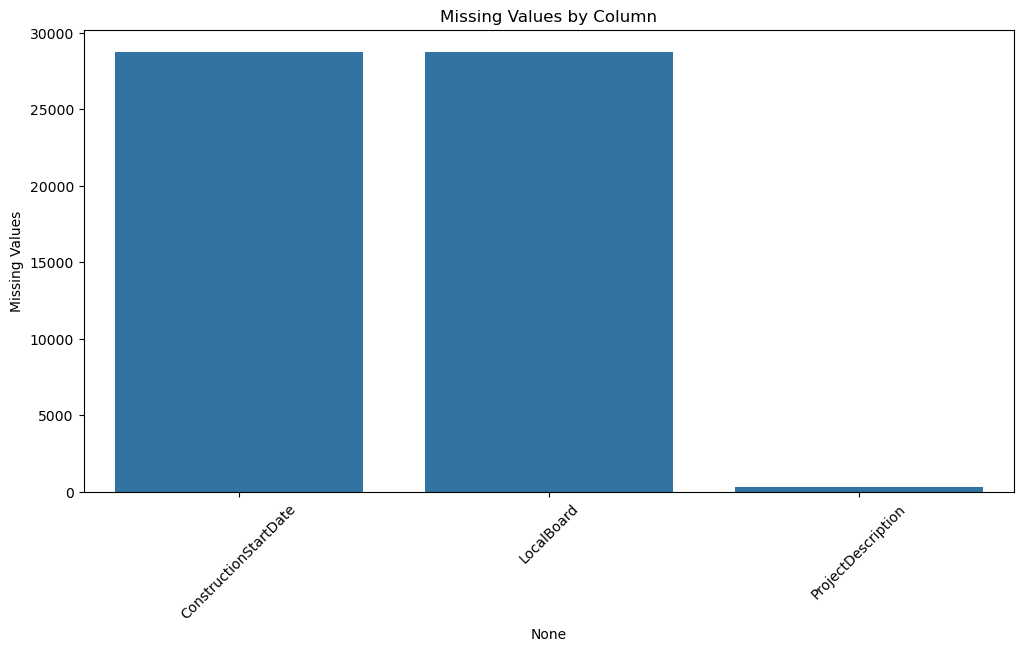

In [8]:
# Missing value check
missing_data = gdf.isnull().sum()
missing_percentage = (missing_data / len(gdf)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

print("Missing Values Analysis:")
print("=" * 50)
print(missing_info[missing_info['Missing Values'] > 0])

plt.figure(figsize=(12, 6))
missing_plot_data = missing_info[missing_info['Missing Values'] > 0]
if len(missing_plot_data) > 0:
    sns.barplot(x=missing_plot_data.index, y='Missing Values', data=missing_plot_data)
    plt.xticks(rotation=45)
    plt.title('Missing Values by Column')
    plt.show()
else:
    print("No missing values to plot.")

In [9]:
# Statistical summary
numerical_cols = gdf.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print("\nStatistical Summary of Numerical Columns:")
    print("=" * 50)
    print(gdf[numerical_cols].describe().T)
else:
    print("No numerical columns to summarize.")

categorical_cols= gdf.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("\nCategorical Columns Summary:")
    print("=" * 50)
    for col in categorical_cols:
        print(f"\nColumn: {col}")
        print(f" Unique values: {gdf[col].nunique()}")
        if gdf[col].nunique() <= 10:
            print(gdf[col].value_counts())


Statistical Summary of Numerical Columns:
                 count          mean           std       min          25%  \
OBJECTID       29672.0  14836.500000   8565.712930  1.000000  7418.750000   
SHAPE__Area    29672.0   1849.048059  28447.784484  0.046875    14.326172   
SHAPE__Length  29672.0    249.477550    877.658271  0.785680    19.088072   

                        50%           75%           max  
OBJECTID       14836.500000  22254.250000  2.967200e+04  
SHAPE__Area       30.753906    448.785156  3.863363e+06  
SHAPE__Length     35.287572    161.149882  7.649354e+04  

Categorical Columns Summary:

Column: ProjectNo
 Unique values: 29375

Column: ProjectName
 Unique values: 8867

Column: Programme
 Unique values: 4
Programme
Footpath                 19903
Pavement                  7759
Surface Water Channel     1092
1_Active                   918
Name: count, dtype: int64

Column: ProjectDescription
 Unique values: 392

Column: ProjectStatus
 Unique values: 5
ProjectStatus
Pro

In [13]:
# Preprocessing copy
gdf_clean = gdf.copy()

print("Handling missing values...")

for col in gdf_clean.columns:
    if col == "geometry":
        continue  # Skip geometry column

    if gdf_clean[col].isnull().sum() > 0:
        print(f"Column '{col}' has {gdf_clean[col].isnull().sum()} missing values.")

        if gdf_clean[col].dtype in [np.float64, np.int64]:
            gdf_clean[col] = gdf_clean[col].fillna(gdf_clean[col].median())
            print(f"  Filled missing numerical values in '{col}' with median: {gdf_clean[col].median()}")
        else:
            if gdf_clean[col].notna().sum() > 0:
                mode_value = gdf_clean[col].mode()
                if len(mode_value) > 0:
                    gdf_clean[col] = gdf_clean[col].fillna(mode_value[0])
                    print(f"  Filled with mode: {mode_value[0]}")
                else:
                    gdf_clean[col] = gdf_clean[col].fillna("unknown")
                    print(f"  Filled with 'unknown' (no mode available)")
            else:
                gdf_clean[col] = gdf_clean[col].fillna("unknown")
                print(f"  Filled with 'unknown' (all values were missing)")
    else:
        print(f"Column '{col}' has no missing values")

print("\nMissing values after imputation:")
print(gdf_clean.isnull().sum())

Handling missing values...
Column 'ProjectNo' has no missing values
Column 'ProjectName' has no missing values
Column 'Programme' has no missing values
Column 'ProjectDescription' has 280 missing values.
  Filled with mode: Renewal - Footpath
Column 'ProjectStartDate' has no missing values
Column 'ProjectEndDate' has no missing values
Column 'ConstructionStartDate' has 28754 missing values.
  Filled with mode: 2023-08-16 00:00:00+00:00
Column 'ProjectStatus' has no missing values
Column 'LocalBoard' has 28754 missing values.
  Filled with mode: Waitematā
Column 'ProjectSource' has no missing values
Column 'OBJECTID' has no missing values
Column 'SHAPE__Area' has no missing values
Column 'SHAPE__Length' has no missing values

Missing values after imputation:
ProjectNo                0
ProjectName              0
Programme                0
ProjectDescription       0
ProjectStartDate         0
ProjectEndDate           0
ConstructionStartDate    0
ProjectStatus            0
LocalBoard      

In [14]:
# Date columns identifications
date_columns = [col for col in gdf_clean.columns if any(keyword in col.lower() for keyword in ['date', 'time', 'year'])]

print("Date columns found:", date_columns)

for col in date_columns:
    try:
        gdf_clean[col] = pd.to_datetime(gdf_clean[col], errors='coerce')
        print(f"Converted {col} to datetime")
    except:
        print(f"Could not convert {col} to datetime")

gdf_clean['geometry_type'] = gdf_clean.geometry.type
gdf_clean['area'] = gdf_clean.geometry.area
gdf_clean['centroid'] = gdf_clean.geometry.centroid

print("\nAdded geometry features:")
print(f"- Geometry type: {gdf_clean['geometry_type'].value_counts().to_dict()}")
print(f"- Area statistics: Min={gdf_clean['area'].min():.2f}, Max={gdf_clean['area'].max():.2f}")

Date columns found: ['ProjectStartDate', 'ProjectEndDate', 'ConstructionStartDate']
Converted ProjectStartDate to datetime
Converted ProjectEndDate to datetime
Converted ConstructionStartDate to datetime

Added geometry features:
- Geometry type: {'Polygon': 29584, 'MultiPolygon': 88}
- Area statistics: Min=0.00, Max=0.00


In [15]:
# Remove duplicates and Clean Tex Columns
initial_count = len(gdf_clean)
gdf_clean = gdf_clean.drop_duplicates()
final_count = len(gdf_clean)
duplicates_removed = initial_count - final_count

print(f"Removed {duplicates_removed} duplicate rows")

text_columns = gdf_clean.select_dtypes(include=['object']).columns
for col in text_columns:
    gdf_clean[col] = gdf_clean[col].astype(str).str.strip().str.title()
    print(f"Cleaned text in column: {col}")

print(f"\nFinal dataset shape: {gdf_clean.shape}")

Removed 0 duplicate rows
Cleaned text in column: ProjectNo
Cleaned text in column: ProjectName
Cleaned text in column: Programme
Cleaned text in column: ProjectDescription
Cleaned text in column: ProjectStatus
Cleaned text in column: LocalBoard
Cleaned text in column: ProjectSource
Cleaned text in column: geometry_type

Final dataset shape: (29672, 17)


Spatial Analysis:
Total area covered: 0.00 square units
Average area per feature: 0.00 square units
Bounding box: [174.4159728  -37.27291016 175.1967978  -36.14182946]


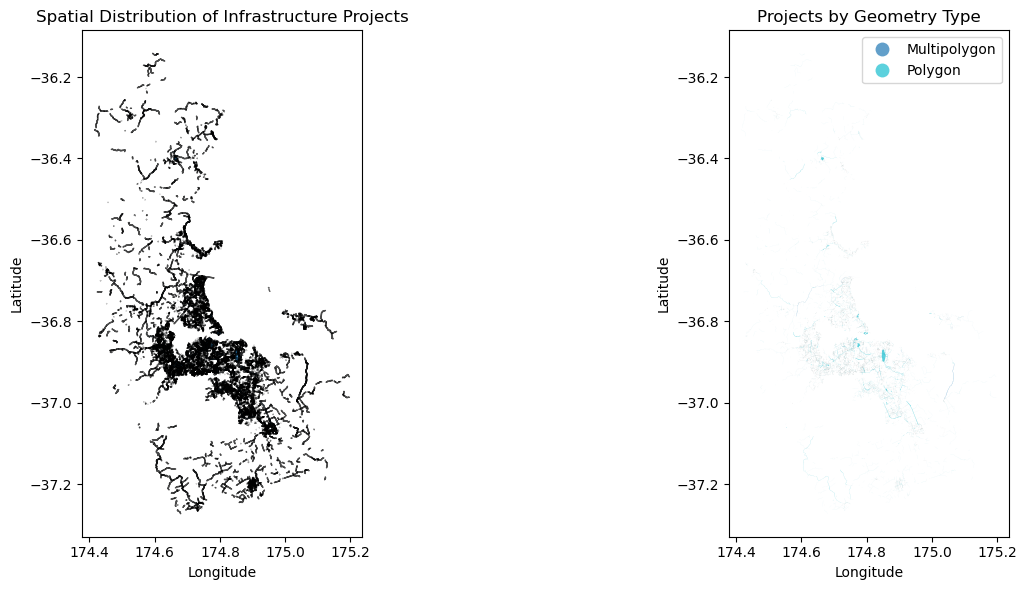

In [16]:
# Spatial Analysis
print("Spatial Analysis:")
print("=" * 50)
print(f"Total area covered: {gdf_clean.area.sum():.2f} square units")
print(f"Average area per feature: {gdf_clean.area.mean():.2f} square units")
print(f"Bounding box: {gdf_clean.total_bounds}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

gdf_clean.plot(ax=ax1, alpha=0.7, edgecolor='black')
ax1.set_title('Spatial Distribution of Infrastructure Projects')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

gdf_clean.plot(ax=ax2, column='geometry_type', categorical=True, legend=True, alpha=0.7)
ax2.set_title('Projects by Geometry Type')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [ ]:
# Create a copy for saving 
gdf_to_save = gdf_clean.copy()

geometry_columns = gdf_to_save.select_dtypes(include=['geometry']).columns.tolist()
print("Geometry columns found:", geometry_columns)

if len(geometry_columns) > 1:
    print("Multiple geometry columns detected. Handling...")
    
    for geom_col in geometry_columns:
        if geom_col != 'geometry':
            gdf_to_save[f"{geom_col}_wkt"] = gdf_to_save[geom_col].to_wkt()
            gdf_to_save = gdf_to_save.drop(columns=[geom_col])
            print(f"Converted {geom_col} to WKT and dropped original")

final_geometry_cols = gdf_to_save.select_dtypes(include=['geometry']).columns.tolist()
print("Final geometry columns:", final_geometry_cols)

output_path = r"C:\Users\mathe\Downloads\AT_Infrastructure_Projects_CLEANED.geojson"
gdf_to_save.to_file(output_path, driver='GeoJSON')

print(f"Preprocessed dataset saved to: {output_path}")
print(f"Final dataset info:")
print(f"- Rows: {len(gdf_to_save)}")
print(f"- Columns: {len(gdf_to_save.columns)}")
print(f"- Geometry types: {gdf_to_save.geometry.type.unique()}")

Geometry columns found: ['geometry', 'centroid']
Multiple geometry columns detected. Handling...
Converted centroid to WKT and dropped original
Final geometry columns: ['geometry']
Preprocessed dataset saved to: C:\Users\mathe\Downloads\AT_Infrastructure_Projects_CLEANED.geojson
Final dataset info:
- Rows: 29672
- Columns: 17
- Geometry types: ['Polygon' 'MultiPolygon']


In [20]:
# Generate a preprocessing summary report
print("PREPROCESSING SUMMARY REPORT")
print("=" * 60)
print(f"Original dataset shape: {gdf.shape}")
print(f"Cleaned dataset shape: {gdf_clean.shape}")
print(f"Rows removed: {gdf.shape[0] - gdf_clean.shape[0]}")
print(f"Columns in final dataset: {len(gdf_clean.columns)}")
print(f"Missing values handled: {gdf.isnull().sum().sum() - gdf_clean.isnull().sum().sum()}")
print(f"Duplicate rows removed: {duplicates_removed}")
print(f"Geometry types: {gdf_clean.geometry_type.value_counts().to_dict()}")
print(f"Data saved to: {output_path}")

PREPROCESSING SUMMARY REPORT
Original dataset shape: (29672, 14)
Cleaned dataset shape: (29672, 17)
Rows removed: 0
Columns in final dataset: 17
Missing values handled: 57788
Duplicate rows removed: 0
Geometry types: {'Polygon': 29584, 'Multipolygon': 88}
Data saved to: C:\Users\mathe\Downloads\AT_Infrastructure_Projects_CLEANED.geojson
